<a href="https://colab.research.google.com/github/Seng-Pan/Simbolo_AI_Project/blob/master/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Necessary Libiraries
import os
import numpy as np
import shutil
import glob
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dir = 'drive/My Drive/PaymentReceipt/dataset_cnn/train'
test_dir = 'drive/My Drive/PaymentReceipt/dataset_cnn/test'
val_dir = 'drive/My Drive/PaymentReceipt/dataset_cnn/val'

# Dataset for training and evaluation
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=val_dir, transform=data_transform)

# batch size
mini_batch_size = 16

# Load Data
train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=mini_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False)

class_names = ('AYAPay', 'CBPay', 'KPay', 'Other', 'WavePay')

In [ ]:
import torchvision.models as models
import torch.nn as nn

# model
model_rn = models.resnet18(pretrained=True)
print (model_rn)

# Fine-Tuning
for param in model_rn.parameters():
    param.requires_grad = False

model_rn.fc = nn.Linear(model_rn.fc.in_features, len(class_names), bias=False)

# Fine-Tuning
for param in model_rn.fc.parameters():
    param.requires_grad = True

print(model_rn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def check_gpu():

  use_gpu = torch.cuda.is_available()
  unit = "cpu"

  if use_gpu:
    print ("-------GPU Mode--------")
    unit = "cuda"

  else:
    print ("-------CPU Mode--------")

  device = torch.device(unit)

  return device

In [ ]:
def train_model(model, dataset_loader, optimizer, device):

    model.train()

    loss_summary = 0
    correct = 0

    train_num = len(dataset_loader.dataset)

    for data, target in dataset_loader:

        input_datas, labels = data.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(input_datas)

        loss = criterion(predicted, labels)
        loss_summary += loss.item()

        loss.backward()

        optimizer.step()

        pred_labels = torch.max(predicted, 1)[1]
        correct += (pred_labels == labels).sum().item()

    average_loss = loss_summary / train_num
    accuracy = correct / train_num

    return model, average_loss, accuracy

def eval_model(model, dataset_loader, device):

  model.eval()

  loss_summary = 0
  correct = 0
  test_num = len(dataset_loader.dataset)

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      loss = criterion(predicted, labels)
      loss_summary += loss.item()

      pred_labels = torch.max(predicted, 1)
      correct += (pred_labels[1] == labels).sum().item()

  average_loss = loss_summary / test_num
  accuracy = correct / test_num

  return average_loss, accuracy

def plot_graph(train, test, label):

    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.ylabel(label)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_model_checkpoint(model, acc, max_acc, epoch, path):

    if acc > max_acc:
        torch.save(model.state_dict(), path.format(epoch))
        return acc

    else:
        return max_acc

def training(model, epoch_num, path, optimizer):

    max_acc = 0
    max_epoch_size = epoch_num

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    # Check GPU
    device = check_gpu()
    model = model.to(device)

    print("Start Training!")
    for epoch in range(max_epoch_size):
        print('Epoch: {}'.format(epoch))

        # training
        model, loss, acc = train_model(model, train_loader, optimizer, device)
        train_losses.append(loss)
        train_acc.append(acc)
        print("Train loss: {} acc: {}".format(loss, acc))

        # Evaluation while training
        loss, acc = eval_model(model, val_loader, device)
        val_losses.append(loss)
        val_acc.append(acc)
        print("Val loss: {} acc: {}\n\n".format(loss, acc))

        # Save the model when accuracy improves.
        max_acc = save_model_checkpoint(model, acc, max_acc, epoch, path)

    print("finish Training")
    print('Max Accuracy {}'.format(max_acc))

    # plot for loss
    plot_graph(train_losses, val_losses, 'Loss')

    # plot for accuracy
    plot_graph(train_acc, val_acc, 'Accuracy')

-------CPU Mode--------
Start Training!
Epoch: 0
Train loss: 0.10024225824284104 acc: 0.27358490566037735
Val loss: 0.1043342199980044 acc: 0.3137254901960784


Epoch: 1
Train loss: 0.08442650013749704 acc: 0.4559748427672956
Val loss: 0.08300787853259667 acc: 0.6176470588235294


Epoch: 2
Train loss: 0.07203881208251857 acc: 0.5817610062893082
Val loss: 0.0690142857093437 acc: 0.7254901960784313


Epoch: 3
Train loss: 0.062043288406336085 acc: 0.6823899371069182
Val loss: 0.05965349195050258 acc: 0.7254901960784313


Epoch: 4
Train loss: 0.06124385966444915 acc: 0.6666666666666666
Val loss: 0.05835516429414936 acc: 0.6862745098039216


Epoch: 5
Train loss: 0.05478066918235155 acc: 0.7295597484276729
Val loss: 0.045644216385542176 acc: 0.7941176470588235


Epoch: 6
Train loss: 0.053570360601323204 acc: 0.7169811320754716
Val loss: 0.05704137478388992 acc: 0.696078431372549


Epoch: 7
Train loss: 0.04626741480527434 acc: 0.779874213836478
Val loss: 0.04693626334854201 acc: 0.76470588235

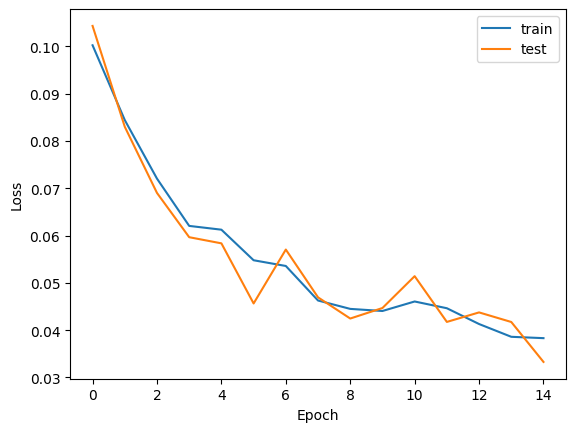

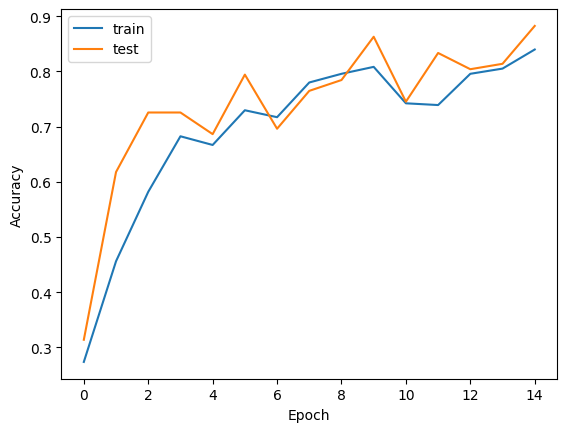

In [ ]:
epoch = 15
model_path = '/content/drive/My Drive/PaymentReceipt/model_cnn'
file_output_path = model_path + '/resnet18_{:02}.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_rn.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

if not os.path.isdir(model_path):
   os.makedirs(model_path)

# Starting model
training(model_rn, epoch, file_output_path, optimizer)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, y_true, y_pred, classes):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def clf_report(target ,pred):
    cm = confusion_matrix(target, pred)
    plot_confusion_matrix(cm,target, pred, class_names)
    print (classification_report(target ,pred))

def detail_eval(model, dataset_loader):

  device = check_gpu()
  model = model.to(device)

  model.eval()

  teach_labels_array = []
  pred_labels_array = []

  with torch.no_grad():
    for data, target in dataset_loader:

      input_datas, labels = data.to(device), target.to(device)

      predicted = model(input_datas)

      pred_labels = torch.max(predicted, 1)

      teach_labels_array.extend(labels.cpu().numpy())
      pred_labels_array.extend(pred_labels[1].cpu().numpy())

  # Confusion-Matrix & Classification_report
  clf_report(teach_labels_array, pred_labels_array)

<ipython-input-60-3a66570d57c8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_rn.load_state_dict(torch.load(load_path))


-------CPU Mode--------


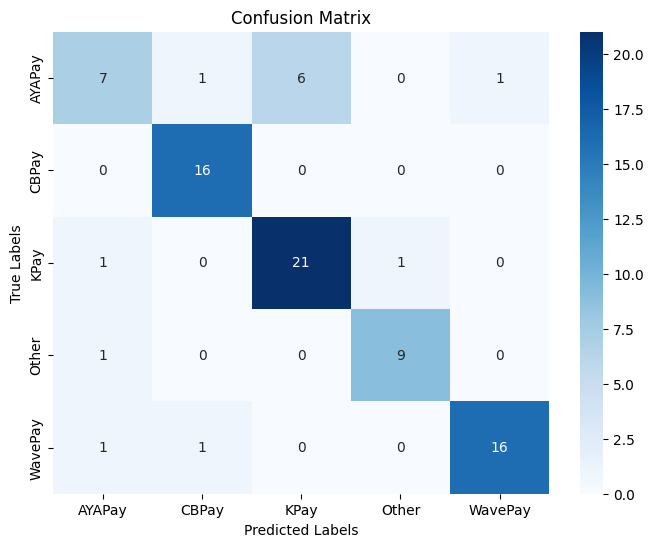

              precision    recall  f1-score   support

           0       0.70      0.47      0.56        15
           1       0.89      1.00      0.94        16
           2       0.78      0.91      0.84        23
           3       0.90      0.90      0.90        10
           4       0.94      0.89      0.91        18

    accuracy                           0.84        82
   macro avg       0.84      0.83      0.83        82
weighted avg       0.84      0.84      0.83        82

-------CPU Mode--------


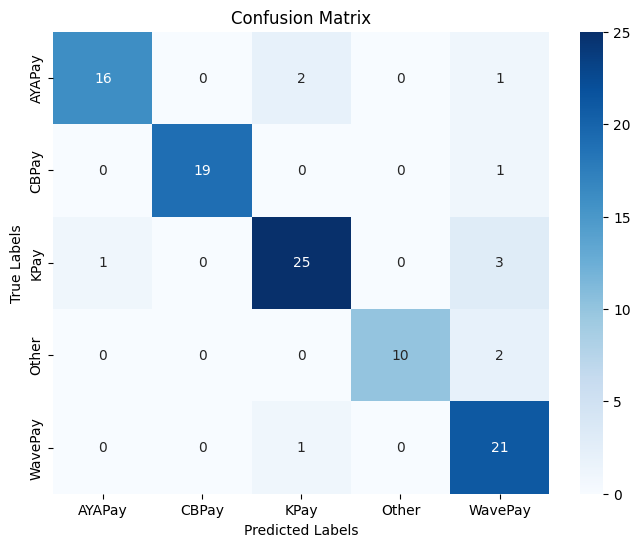

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       1.00      0.95      0.97        20
           2       0.89      0.86      0.88        29
           3       1.00      0.83      0.91        12
           4       0.75      0.95      0.84        22

    accuracy                           0.89       102
   macro avg       0.92      0.89      0.90       102
weighted avg       0.90      0.89      0.89       102



In [ ]:
import torchvision.models as models
import torch.nn as nn

load_path = model_path + '/resnet18_14.pth'

model_rn.load_state_dict(torch.load(load_path))

detail_eval(model_rn, test_loader)
detail_eval(model_rn, val_loader)